In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
residual = layers.Conv2D(64, 1)(residual)
x = layers.add([x, residual])

In [4]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
residual = x
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
residual = layers.Conv2D(64, 1, strides=2)(residual)
x = layers.add([x, residual])

In [5]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
    residual = x
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(2, padding='same')(x)
        residual = layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters, 1)(residual)
    x = layers.add([x, residual])
    return x

x = residual_block(x, filters=32, pooling=True)
x = residual_block(x, filters=64, pooling=True)
x = residual_block(x, filters=128, pooling=False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_9[0][0]']               
                                                                                              

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)

In [ ]:
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# use activation after batch normalization

In [7]:
inputs = keras.Input(shape=(180,180,3))

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_5[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)             (None, 176, 176, 32  2400        ['rescaling_1[0][0]']      

In [9]:
from tensorflow import keras
model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

In [7]:
import numpy as np

In [8]:
img_path = keras.utils.get_file(
    fname='cat.jpg',
    origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

In [9]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [10]:
img_tensor = get_img_array(img_path, target_size=(180,180))

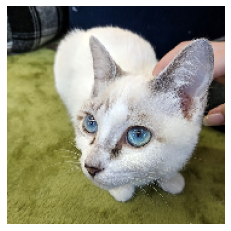

In [11]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()

In [15]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [16]:
activations = activation_model.predict(img_tensor)

In [41]:
x_layer_activation = activations[8]

In [42]:
print(x_layer_activation.shape)

(1, 7, 7, 256)


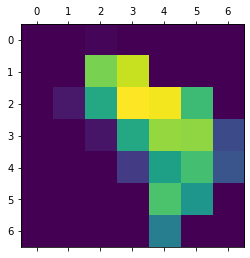

In [45]:
plt.matshow(x_layer_activation[0,:,:,45],cmap='viridis')

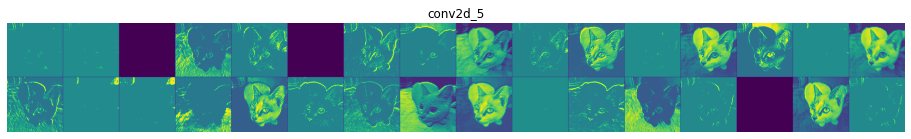

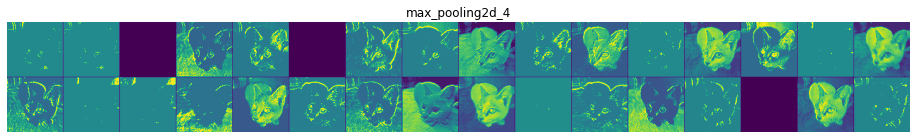

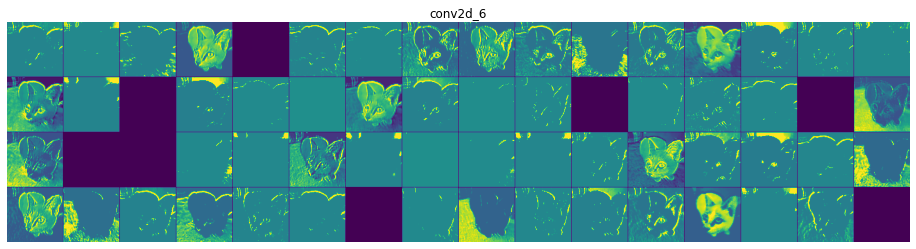

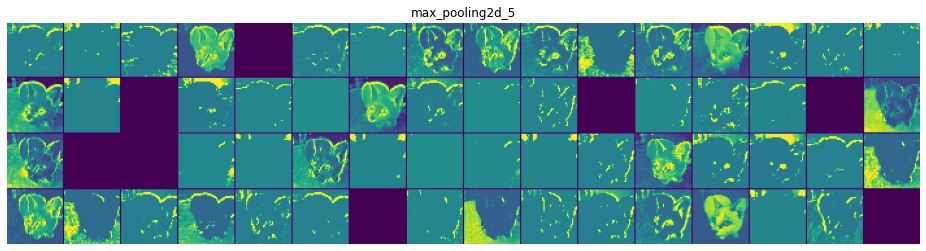

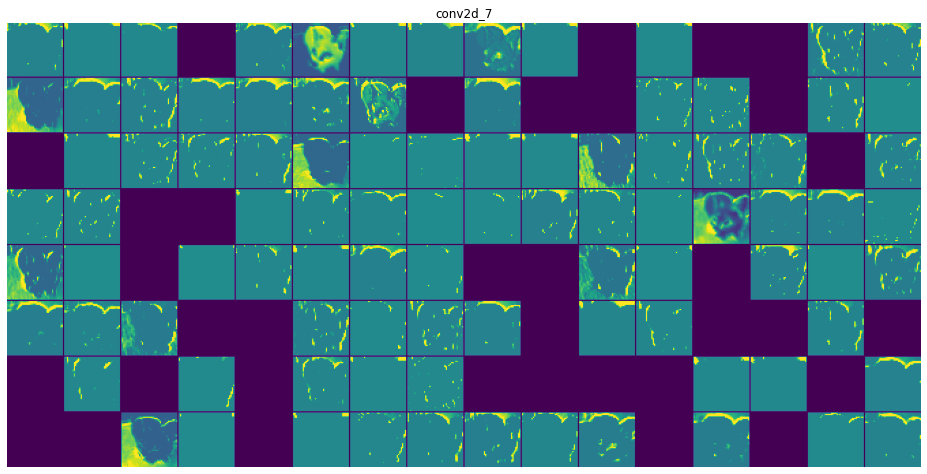

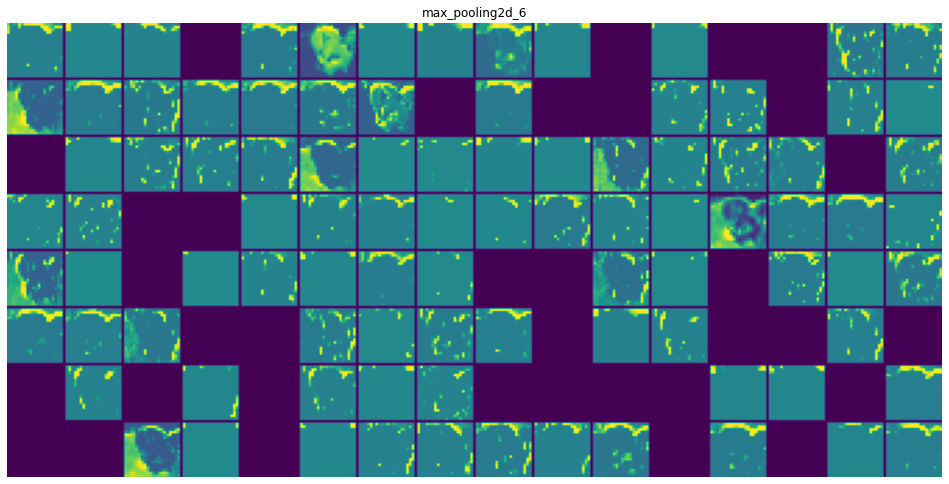

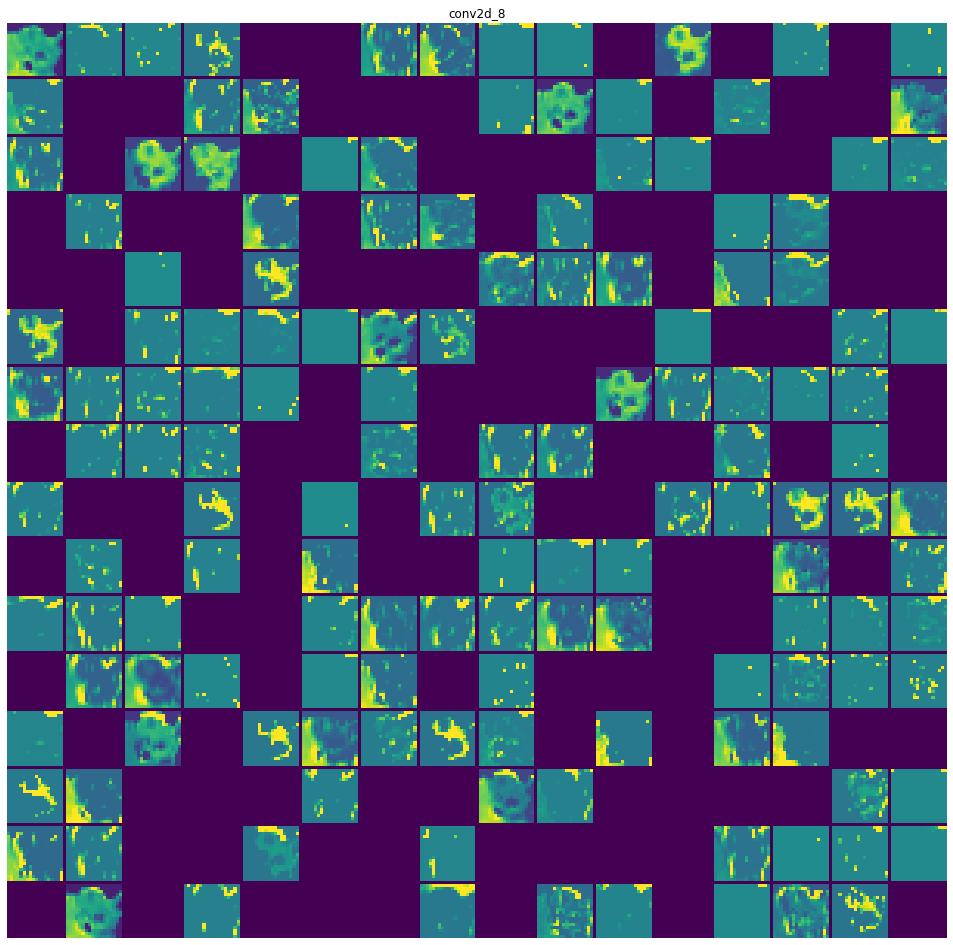

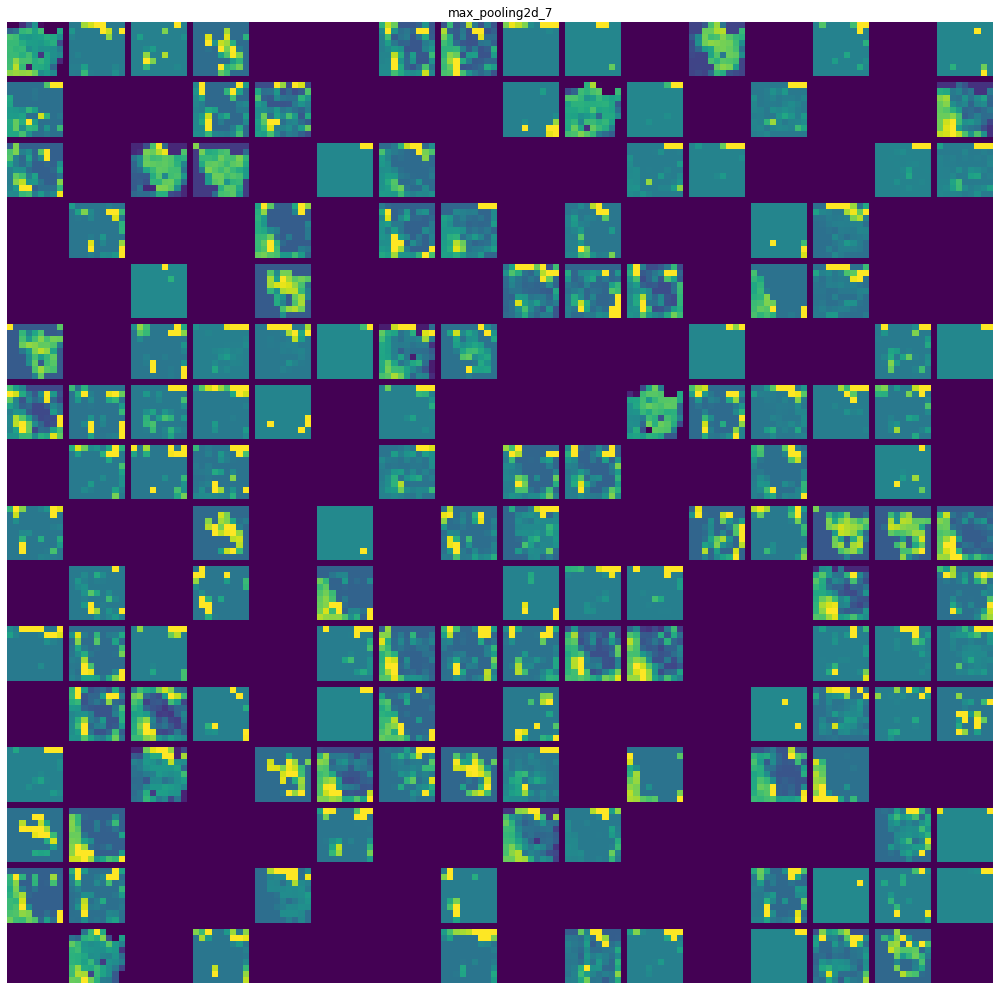

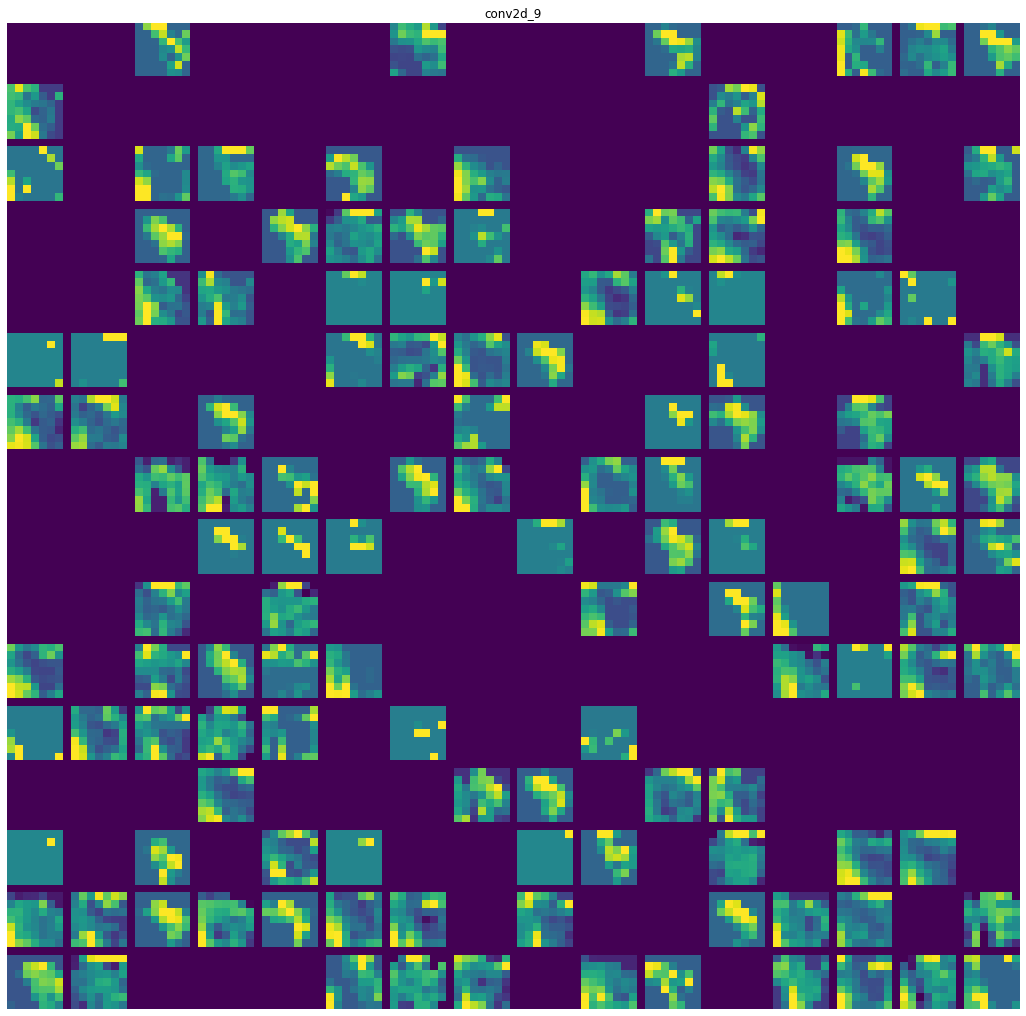

In [36]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size= layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size+1)*n_cols-1,images_per_row*(size+1)-1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col*images_per_row + row
            channel_image = layer_activation[0,:,:,channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[
                col * (size +1) : (col+1)*size+col,
                row * (size+1):(row+1)*size +row] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [2]:
model = keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False)

In [3]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [4]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

In [5]:
layer_name = 'block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [12]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor))

In [13]:
import tensorflow as tf

In [14]:
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [15]:
@tf.function

def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

In [23]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

In [24]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :]
    return image

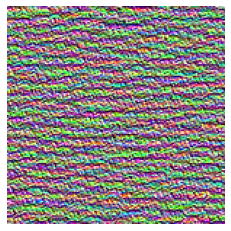

In [25]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [19]:
all_images = []
for filter_index in range(64):
    print(f'Processing filter {filter_index}')
    image = deprocess_image(generate_filter_pattern(filter_index))
    all_images.append(image)
    
margin = 5
n = 8
cropped_width = img_width - 25*2
cropped_height = img_height - 25*2
width = n*cropped_width + (n-1)*margin
height = n*cropped_height + (n-1)*margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i*n+j]
        stitched_filters[
            (cropped_width + margin) * i
            :(cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j
            :(cropped_height + margin) * j + cropped_height,
            
           :] = image
keras.utils.save_img(
    f'filters_for_layer_{layer_name}.png', stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

In [27]:
model = keras.applications.xception.Xception(weights='imagenet')

91897856/91884032 [==============================] - 618s 7us/step


In [29]:
img_path = keras.utils.get_file(
    fname='elephant.jpg',
    origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')

745472/733657 [==============================] - 83s 111us/step


In [30]:
def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

In [31]:
img_array = get_img_array(img_path, target_size = (299,299))

In [32]:
preds = model.predict(img_array)

In [33]:
print(keras.applications.xception.decode_predictions(preds,top=3)[0])

49152/35363 [=========================================] - 0s 3us/step
[('n02504458', 'African_elephant', 0.86993957), ('n01871265', 'tusker', 0.07695636), ('n02504013', 'Indian_elephant', 0.023541808)]


In [34]:
np.argmax(preds[0])

386

In [36]:
last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = [
    'avg_pool',
    'predictions',
]

last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [37]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

In [38]:
import tensorflow as tf

In [39]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
    
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [40]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

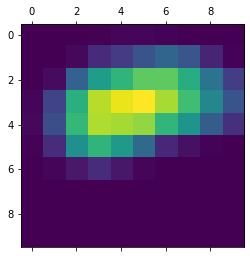

In [41]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [42]:
import matplotlib.cm as cm

In [44]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)
heatmap = np.uint8(255*heatmap)

jet = cm.get_cmap('jet')
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = 'elephant_cam.jpg'
superimposed_img.save(save_path)